---

#Human versus AI Distinguishment

##Group 2 - AAI-590: Capstone Project

##Jason Raimondi, Shane Schipper, and Jeremy Cryer

##2024-04-15

###Custom_Transformer.ipynb

###Data Source:

Kaggle - AI Vs Human Text

https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text

###GitHub Repository:

https://github.com/jeraimondi/aai-capstone-ai-content-detector

---

# Environment Prep

## Install Required Packages

In [1]:
!pip install torcheval # evaluation metrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.5 MB/s eta 0:00:00


## Load Required Libraries

In [2]:
import math # mathematical functions
import matplotlib.pyplot as plt # plotting
import numpy as np # array manipulation
import pandas as pd # data analysis
import random # random number generator
import seaborn as sns # visualizations
import torch # machine learning framework
import torch.nn as nn # neural networks
import torch.nn.functional as F # neural network functions
import torchtext # data processing utilities
from google.colab import drive # connect to drive storage
from sklearn.model_selection import train_test_split # splitter function
from sklearn.utils import resample # resample dataset to balance classes
from torch import Tensor # multi-dimensional matrix
from torch.utils.data import DataLoader # create DataLoaders
from torch.utils.data import Dataset # create Torch datasets

# binary metrics
from torcheval.metrics import BinaryAccuracy
from torcheval.metrics import BinaryConfusionMatrix
from torcheval.metrics import BinaryF1Score
from torcheval.metrics import BinaryPrecision
from torcheval.metrics import BinaryRecall

from torchtext.data import get_tokenizer # tokenizer function
from torchtext.vocab import build_vocab_from_iterator # build vocabulary
from transformers import DistilBertConfig, DistilBertModel # DistilBERT
from tqdm import tqdm # progress bars

## Set Random Seeds

In [3]:
# set random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)

## Verify GPU Availability

In [4]:
# set device for GPU/CPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# verify GPU availability
if device.type == 'cuda':
    print('GPU is available!')
    print('-----------------')
    current_device = torch.cuda.current_device()
    print('Current Device:', current_device)
    print('Device Name:', torch.cuda.get_device_name(current_device))
else:
    raise SystemError('GPU device not found!')

GPU is available!
-----------------
Current Device: 0
Device Name: Tesla T4


# Dataset Prep

## Upload Dataset

In [5]:
# connect google drive
drive.mount('/content/drive') # uncomment to mount google drive

# read csv file into dataframe
ai_df = pd.read_csv('drive/MyDrive/AI_Human.csv')

# display dataframe
ai_df

Mounted at /content/drive


,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0


## Rename Columns

In [6]:
# rename columns in place
ai_df.rename({'text': 'orig_str', 'generated': 'label'}, axis='columns', inplace=True)

# display dataframe
ai_df

,orig_str,label
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0


## Balance Classes

In [7]:
# separate classes to support resampling
class_majority = ai_df[ai_df['label'] == 0.0]
class_minority = ai_df[ai_df['label'] == 1.0]

# print class distribution before resampling
print('Class Distribution BEFORE Resampling:')
print('-------------------------------------')
print('Majority Samples (Human - Class 0):', len(class_majority))
print('Minority Samples (AI - Class 1):', len(class_minority))

# resample (downsample) majority class to equal minority class
class_majority_resample = resample(class_majority, replace=False, n_samples=len(class_minority), random_state=0)

# join dataframes
ai_df_balanced = pd.concat([class_minority, class_majority_resample])

# obtain class counts from new dataframe to verify
class_count_human = len(ai_df_balanced[ai_df_balanced['label'] == 0.0])
class_count_ai = len(ai_df_balanced[ai_df_balanced['label'] == 1.0])

# print class distribution after resampling
print('\nClass Distribution AFTER Resampling:')
print('-------------------------------------')
print('Majority Samples (Human - Class 0):', class_count_human)
print('Minority Samples (AI - Class 1):', class_count_ai)

Class Distribution BEFORE Resampling:
-------------------------------------
Majority Samples (Human - Class 0): 305797
Minority Samples (AI - Class 1): 181438

Class Distribution AFTER Resampling:
-------------------------------------
Majority Samples (Human - Class 0): 181438
Minority Samples (AI - Class 1): 181438


## Define Tokenize Function

In [8]:
# function to generate vocabulary from original strings
def yield_tokens(orig_strings):
    for str in orig_strings:
        yield tokenizer(str)

# Custom Model Prep

## Review DistilBERT Config

In [9]:
# initialize DistilBERT configuration
configuration = DistilBertConfig()

# initialize a DistilBERT model using configuration
model = DistilBertModel(configuration)

# review configuration
print('DistilBERT Config:\n', model.config)

DistilBERT Config:
 DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.38.2",
  "vocab_size": 30522
}



## Build Torch Datasets Class

In [10]:
# define class to build torch dataset required for pytorch training
class TorchDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.labels = labels
        for text in texts:
            tokenized_text = tokenizer(text)
            self.input_ids.append([vocab[token] for token in tokenized_text])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        out = {
                'input_id': self.input_ids[idx],
                'label': self.labels.iloc[idx]
        }

        return out

## Build and Split Datasets

In [11]:
# define X and y from our entire balanced dataframe
X = ai_df_balanced['orig_str']
y = ai_df_balanced['label']

# first split dataset into 90% training and 10% testing, shuffle and stratify classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, random_state=0, shuffle=True, stratify=y)

# next split resulting training set into 80% training and 20% validation, shuffle and stratify classes
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.20, random_state=0, shuffle=True, stratify=y_train)

# generate tokenizer function
tokenizer = get_tokenizer('basic_english')

# build vocabulary
default_index = 0
vocab = build_vocab_from_iterator(yield_tokens(X_train), specials=['<unk>'])
vocab.set_default_index(default_index)

# define number of embeddings
num_embeddings = len(vocab)

# embedding dimensions
embedding_dim = 768

# call function to build torch datasets
train_dataset = TorchDataset(X_train, y_train, tokenizer)
val_dataset = TorchDataset(X_val, y_val, tokenizer)
test_dataset = TorchDataset(X_test, y_test, tokenizer)

# print dataset sizes
print('Dataset sizes AFTER splitting:')
print('------------------------------')
print('Train:', len(train_dataset))
print('Val:', len(val_dataset))
print('Test:', len(test_dataset))

Dataset sizes AFTER splitting:
------------------------------
Train: 261270
Val: 65318
Test: 36288


## Create Dataloaders

In [12]:
# define custom collate_fn to zero-pad sequences
def collate_fn_padding(batch):

    # obtain input_ids and labels from batch, convert to torch tensors
    input_ids = [torch.tensor(sample['input_id']).long().to(device) for sample in batch]
    labels = torch.tensor([sample['label'] for sample in batch]).float().to(device)

    # pad input sequences to maximum sequence length in batch
    max_length = max(len(input_id) for input_id in input_ids)
    padded_input_id = [F.pad(input=input_id, pad=(0, max_length - len(input_id)), mode='constant', value=0) for input_id in input_ids]

    # put the tensors together in a single batch
    padded_input_ids = torch.stack(padded_input_id)

    # convert labels to 2d float values for compatibility
    labels = labels.float()
    labels = labels.unsqueeze(1)

    return padded_input_ids, labels

In [13]:
# create dataloaders for train, val, and test datasets
# specify custom collate_fn
train_dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn_padding, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn_padding, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn_padding, shuffle=True)

### Print Sample Batch Sizes

In [14]:
# obtain inputs and labels of dataloader sample batches
train_inputs, train_labels = next(iter(train_dataloader))
val_inputs, val_labels = next(iter(val_dataloader))
test_inputs, test_labels = next(iter(test_dataloader))

# print sample batch inputs size
print('Sample Batch Inputs Size:')
print('-------------------------')
print('Train:', train_inputs.size())
print('Val:', val_inputs.size())
print('Test:', test_inputs.size())

# print sample batch labels size
print('\nSample Batch Labels Size:')
print('-------------------------')
print('Train:', train_labels.size())
print('Val:', val_labels.size())
print('Test:', test_labels.size())

Sample Batch Inputs Size:
-------------------------
Train: torch.Size([32, 829])
Val: torch.Size([32, 1131])
Test: torch.Size([32, 1015])

Sample Batch Labels Size:
-------------------------
Train: torch.Size([32, 1])
Val: torch.Size([32, 1])
Test: torch.Size([32, 1])


# Custom Transformer

## Define Class for Positional Encoding

In [15]:
# define class for positional encoding
# NOTE* - Class code retrieved and modified from:
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)


    # forward pass
    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_length, embedding_dim]``
        """
        # obtain shape of input tensor
        batch_size, seq_length, embedding_dim = x.size()

        # calculate positional encoding, results in [1, seq_length, 1] shape
        position = torch.arange(seq_length).unsqueeze(0).unsqueeze(-1)

        # calculate divisor term for sine and cosine functions
        div_term = torch.exp(torch.arange(0, self.d_model, 2) * (-math.log(10000.0) / self.d_model))

        # initialize tensor of 0s
        pe = torch.zeros(batch_size, seq_length, self.d_model)

        # calculate sine for even indices and cosine for odd
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)

        # add positional encoding to input tensor, set to same device
        x = x + pe.to(device)

        # apply dropout and return
        return self.dropout(x)

## Define Class for Custom Architecture

In [16]:
# define class to build custom transformer model
class TransformerModel(nn.Module):
    def __init__(
        self,
        num_embeddings, # size of vocab
        embedding_dim, # embedding dimensions
        d_model, # number of expected input features
        nhead, # number of heads for multi-attention
        dim_feedforward, # dimension of feedforward network
        dropout, # dropout value
        activation, # intermediate layer activation function
        num_layers # number of transformer layers
    ):
        super().__init__()

        # embedding layer
        self.embedding_layer = nn.Embedding(num_embeddings, embedding_dim)

        # positional encoding module
        # NOTE* - Module use obtained from:
        # https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # transformer layers
        self.transformer_layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model = d_model, # number of expected input features
                nhead = nhead, # number of heads for multi-attention
                dim_feedforward=dim_feedforward, # dimension of feedforward network
                dropout=dropout, # dropout value
                activation=activation, # intermediate layer activation function
                batch_first=True # (batch, seq, feature) format

            ),
            num_layers=num_layers # number of transformer layers
        )

        # predictive layer, 1 output for binary classification
        self.predictive_layer = nn.Linear(embedding_dim, 1)

        # sigmoid activation function for output between 0 and 1
        self.sigmoid_activation = nn.Sigmoid()


    # function for forward pass
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.pos_encoder(x)
        x = self.transformer_layers(x)
        x = torch.mean(x, dim=1) # mean pooling
        x = self.predictive_layer(x)
        x = self.sigmoid_activation(x)
        return x

## Instantiate Model

In [17]:
# instantiate custom transformer model
custom_model = TransformerModel(
    num_embeddings, # size of vocab
    embedding_dim, # embedding dimensions
    d_model=768, # number of expected input features
    nhead=12, # number of heads for multi-attention
    dim_feedforward=1024, # dimension of feedforward network
    dropout=0.1, # dropout value
    activation='gelu', # intermediate layer activation function
    num_layers=2 # number of transformer layers
)

# use GPU/CPU hardware
custom_model.to(device)

TransformerModel(
  (embedding_layer): Embedding(208251, 768)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_layers): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (predictive_layer): Linear(in_features=768, out_features=1, bias=True)
  (sigmoid_activation): Sigmoid()
)

# Model Training

## Define Training Function

In [18]:
# define training function
def train(
        model,
        save_path,
        train_dataloader,
        val_dataloader,
        num_epochs,
        lr,
        patience
):
    criterion = nn.BCELoss() # binary cross entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # adam optimizer

    # running losses
    train_losses = []
    val_losses = []

    # binary accuracy metric and running accuracies
    metric = BinaryAccuracy(device=device)
    train_accuracies = []
    val_accuracies = []

    # variables to save best model and early stopping
    best_val_accuracy = 0.0 # initial value for comparison
    stalled_training_count = 0 # initialize counter

    # iterate through each epoch
    for epoch in range(num_epochs):

        # reset per-epoch losses and metric
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        metric.reset()

        # training loop
        model.train() # set to train mode

        for inputs, labels in tqdm(train_dataloader, desc='Training'):

            # clear gradients
            optimizer.zero_grad()

            # forward pass, obtain predictions
            outputs = model(inputs)

            # calculate binary cross entropy loss
            loss = criterion(outputs, labels)

            # update metric
            metric.update(outputs.squeeze(), labels.squeeze())

            # backward pass, backpropagation
            loss.backward()

            # model parameter update
            optimizer.step()

            # add loss from current training batch
            epoch_train_loss += loss.item()

        # save running loss and metrics during training
        train_losses.append(epoch_train_loss / len(train_dataloader))
        train_accuracies.append(metric.compute().item())

        # reset metric for validation
        metric.reset()

        # validation loop
        model.eval() # set to eval mode

        # disable gradient computation
        with torch.no_grad():

            for inputs, labels in tqdm(val_dataloader, desc='Validation'):

                # obtain predictions, update metric and val loss
                val_outputs = model(inputs)
                val_loss = criterion(val_outputs, labels)
                metric.update(val_outputs.squeeze(), labels.squeeze())
                epoch_val_loss += val_loss.item()

            # save running loss and metrics during validation
            val_losses.append(epoch_val_loss / len(val_dataloader))
            val_accuracies.append(metric.compute().item())

        # print results after every specified epochs
        if epoch % 1 == 0:
            print(
                ('\nEpoch {}/{} Results --- train_loss: {:.4f} --- train_acc: {:.4f}'
                ' --- val_loss: {:.4f} --- val_acc: {:.4f}\n').format(
                    epoch + 1,
                    num_epochs,
                    train_losses[-1],
                    train_accuracies[-1],
                    val_losses[-1],
                    val_accuracies[-1]
                )
            )

        # save best model upon val accuracy increase
        # otherwise, check for early stopping condition
        if val_accuracies[-1] > best_val_accuracy:
            best_val_accuracy = val_accuracies[-1] # update best val accuracy
            torch.save(model, save_path) # save model
            stalled_training_count = 0 # reset counter
        else:
            stalled_training_count += 1 # increment counter

            # check for early stopping
            if stalled_training_count >= patience:
                print('Early stopping...')
                print('Validation accuracy has not improved for {} epochs.'.format(patience))
                return train_losses, val_losses, train_accuracies, val_accuracies # exit training early

    return train_losses, val_losses, train_accuracies, val_accuracies

## Train Model

In [ ]:
# training parameters
save_path = '/content/drive/MyDrive/models/custom_model.pt' # save best model
num_epochs = 10 # number of epochs to train
lr = 0.001 # learning rate
patience = 2 # early stop if no improvments for this number of epochs

# train model
train_losses, val_losses, train_accuracies, val_accuracies = train(
    custom_model,
    save_path,
    train_dataloader,
    val_dataloader,
    num_epochs,
    lr,
    patience
)

Validation: 100%|██████████| 2042/2042 [05:40<00:00,  5.99it/s]



Epoch 1/10 Results --- train_loss: 0.3343 --- train_acc: 0.8550 --- val_loss: 0.3568 --- val_acc: 0.8458



Validation: 100%|██████████| 2042/2042 [06:00<00:00,  5.66it/s]



Epoch 2/10 Results --- train_loss: 0.1730 --- train_acc: 0.9360 --- val_loss: 0.1649 --- val_acc: 0.9394



Validation: 100%|██████████| 2042/2042 [05:46<00:00,  5.89it/s]



Epoch 3/10 Results --- train_loss: 0.1643 --- train_acc: 0.9405 --- val_loss: 0.1704 --- val_acc: 0.9383



Validation: 100%|██████████| 2042/2042 [06:00<00:00,  5.66it/s]



Epoch 4/10 Results --- train_loss: 0.1665 --- train_acc: 0.9385 --- val_loss: 0.1656 --- val_acc: 0.9400



Validation: 100%|██████████| 2042/2042 [05:58<00:00,  5.69it/s]



Epoch 5/10 Results --- train_loss: 0.1770 --- train_acc: 0.9330 --- val_loss: 0.1919 --- val_acc: 0.9237



Validation: 100%|██████████| 2042/2042 [06:04<00:00,  5.60it/s]



Epoch 6/10 Results --- train_loss: 0.1947 --- train_acc: 0.9249 --- val_loss: 0.2337 --- val_acc: 0.9061



Training:   1%|▏         | 112/8165 [00:45<27:51,  4.82it/s]

## Draw Learning Curves

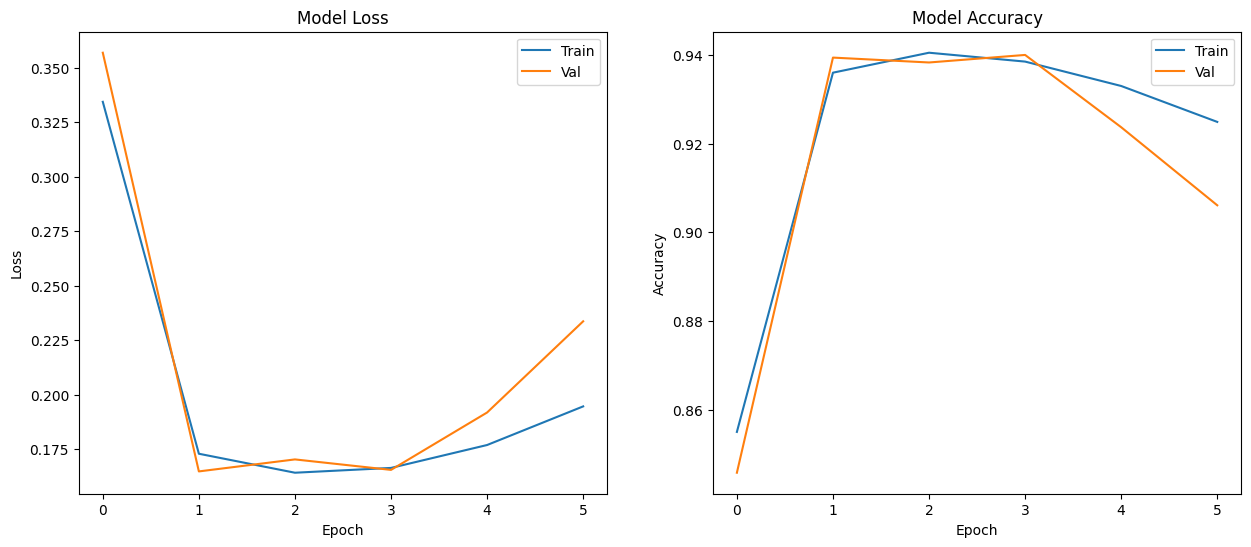

In [27]:
# define losses/accuracies from previous training
# these were not saved, only provided as output during training
train_loss = [0.3343, 0.1730, 0.1643, 0.1665, 0.1770, 0.1947]
val_loss = [0.3568, 0.1649, 0.1704, 0.1656, 0.1919, 0.2337]
train_acc = [0.8550, 0.9360, 0.9405, 0.9385, 0.9330, 0.9249]
val_acc = [0.8458, 0.9394, 0.9383, 0.9400, 0.9237, 0.9061]

# define function to draw learning curves
def learning_curves(train_loss, val_loss, train_acc, val_acc):

    # create subplots
    plt.subplots(1, 2, figsize=(15, 6))

    # plot model loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')

    # plot model accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')

    # show plot
    plt.show()

# call function to draw learning curves
learning_curves(train_loss, val_loss, train_acc, val_acc)

# Model Evaluation

## Load Model

In [22]:
# set to True if needing to load model, False otherwise
load_model = True

# path to model to load
model_path = '/content/drive/MyDrive/models/custom_model.pt'

# load model
if load_model == True:
    if torch.cuda.is_available():
        custom_model = torch.load(model_path) # GPU
    else:
        custom_model = torch.load(model_path, map_location=torch.device('cpu')) # CPU

# set model to eval mode
custom_model.eval()

TransformerModel(
  (embedding_layer): Embedding(208251, 768)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_layers): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (predictive_layer): Linear(in_features=768, out_features=1, bias=True)
  (sigmoid_activation): Sigmoid()
)

## Define Metrics Function

In [23]:
# define function to get model metrics for val and test datasets
def get_model_metrics(model, dataloader, threshold=0.5):

    # initialize metrics
    metric_ba = BinaryAccuracy(threshold=threshold, device=device)
    metric_bp = BinaryPrecision(threshold=threshold, device=device)
    metric_br = BinaryRecall(threshold=threshold, device=device)
    metric_bf1 = BinaryF1Score(threshold=threshold, device=device)
    metric_bcm = BinaryConfusionMatrix(threshold=threshold, device=device)

    # disable gradient computation
    with torch.no_grad():

        # iterate through each batch
        for inputs, labels in tqdm(dataloader, desc='Obtaining Metrics'):

            # obtain predictions, update metric states
            outputs = model(inputs)
            metric_ba.update(outputs.squeeze(), labels.squeeze())
            metric_bp.update(outputs.squeeze(), labels.squeeze())
            metric_br.update(outputs.squeeze(), labels.int().squeeze())
            metric_bf1.update(outputs.squeeze(), labels.squeeze())
            metric_bcm.update(outputs.squeeze(), labels.int().squeeze())

    # compute and save metrics
    score_accuracy = metric_ba.compute().item()
    score_precision = metric_bp.compute().item()
    score_recall = metric_br.compute().item()
    score_f1 = metric_bf1.compute().item()
    bcm = metric_bcm.compute()

    # print metrics
    print('\n')
    print('Binary Accuracy:', '{:.2%}'.format(score_accuracy))
    print('Binary Precision:', '{:.2%}'.format(score_precision))
    print('Binary Recall:', '{:.2%}'.format(score_recall))
    print('Binary F1 Score:', '{:.2%}'.format(score_f1))
    print('\nBinary Confusion Matrix:\n', bcm)
    print('\nTrue Positive:', bcm[0][0].int().item())
    print('False Negative:', bcm[0][1].int().item())
    print('False Positive:', bcm[1][0].int().item())
    print('True Negative:', bcm[1][1].int().item())

    return score_accuracy, score_precision, score_recall, score_f1, bcm

## Evaluate on Validation Set

### Obtain Metrics

In [24]:
# evaluate validation dataset
score_accuracy, score_precision, score_recall, score_f1, bcm = get_model_metrics(custom_model, val_dataloader)

Obtaining Metrics: 100%|██████████| 2042/2042 [17:19<00:00,  1.96it/s]



Binary Accuracy: 93.95%
Binary Precision: 93.71%
Binary Recall: 94.22%
Binary F1 Score: 93.97%

Binary Confusion Matrix:
 tensor([[30595.,  2064.],
        [ 1887., 30772.]], device='cuda:0')

True Positive: 30595
False Negative: 2064
False Positive: 1887
True Negative: 30772


### Build Confusion Matrix

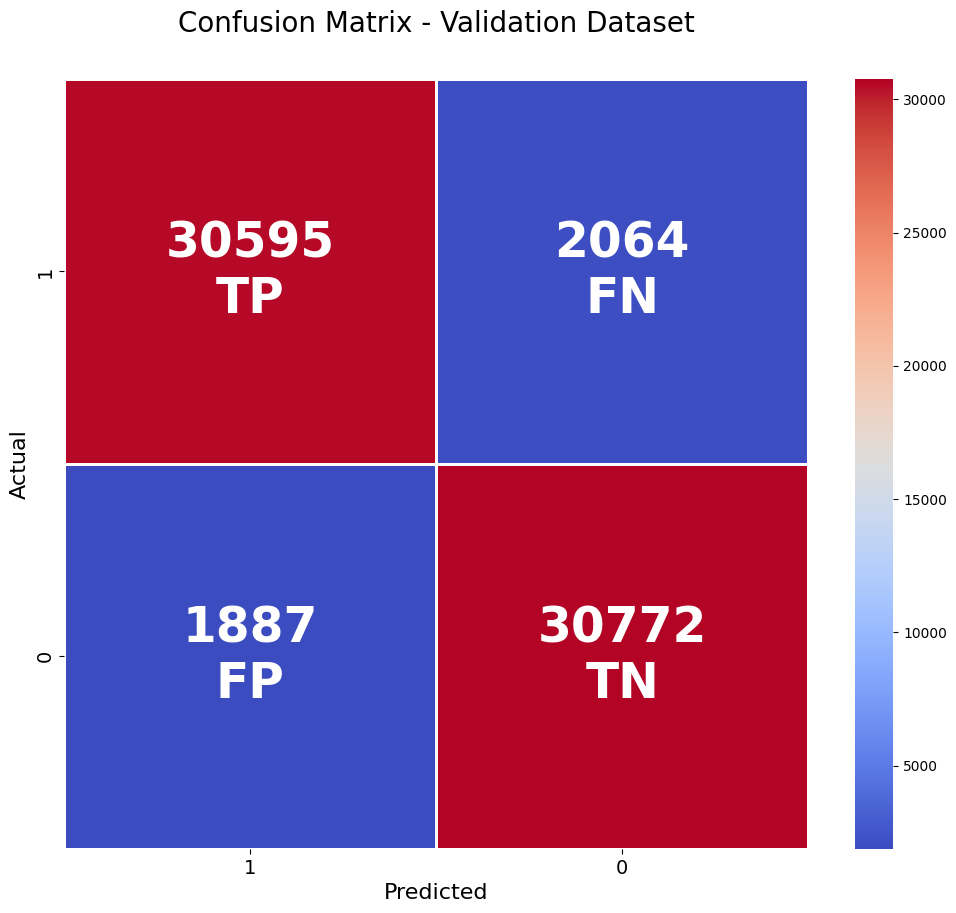

In [26]:
# combine values with text for annotations
tp = str(bcm[0][0].int().item()) + '\nTP'
fn = str(bcm[0][1].int().item()) + '\nFN'
fp = str(bcm[1][0].int().item()) + '\nFP'
tn = str(bcm[1][1].int().item()) + '\nTN'

# create array with annotations
bcm_annot = np.array([tp, fn, fp, tn]).reshape((2,2))

# build and display confusion matrix
plt.figure(figsize = (12,10))
sns.heatmap(data=bcm.cpu(), annot=bcm_annot, annot_kws={'fontsize': 35, 'fontweight': 'heavy'}, fmt='', linewidths=2, linecolor='white', cmap='coolwarm')
plt.title('Confusion Matrix - Validation Dataset', y=1.05, fontsize=20)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.xticks(ticks=[0.5, 1.5],labels=['1', '0'], fontsize=14)
plt.yticks(ticks=[0.5, 1.5],labels=['1', '0'], fontsize=14)
plt.show()

## Evaluate on Test Set

### Obtain Metrics

In [28]:
# evaluate test dataset
score_accuracy, score_precision, score_recall, score_f1, bcm = get_model_metrics(custom_model, test_dataloader)

Obtaining Metrics: 100%|██████████| 1134/1134 [09:16<00:00,  2.04it/s]



Binary Accuracy: 94.14%
Binary Precision: 93.98%
Binary Recall: 94.31%
Binary F1 Score: 94.15%

Binary Confusion Matrix:
 tensor([[17048.,  1096.],
        [ 1032., 17112.]], device='cuda:0')

True Positive: 17048
False Negative: 1096
False Positive: 1032
True Negative: 17112


### Build Confusion Matrix

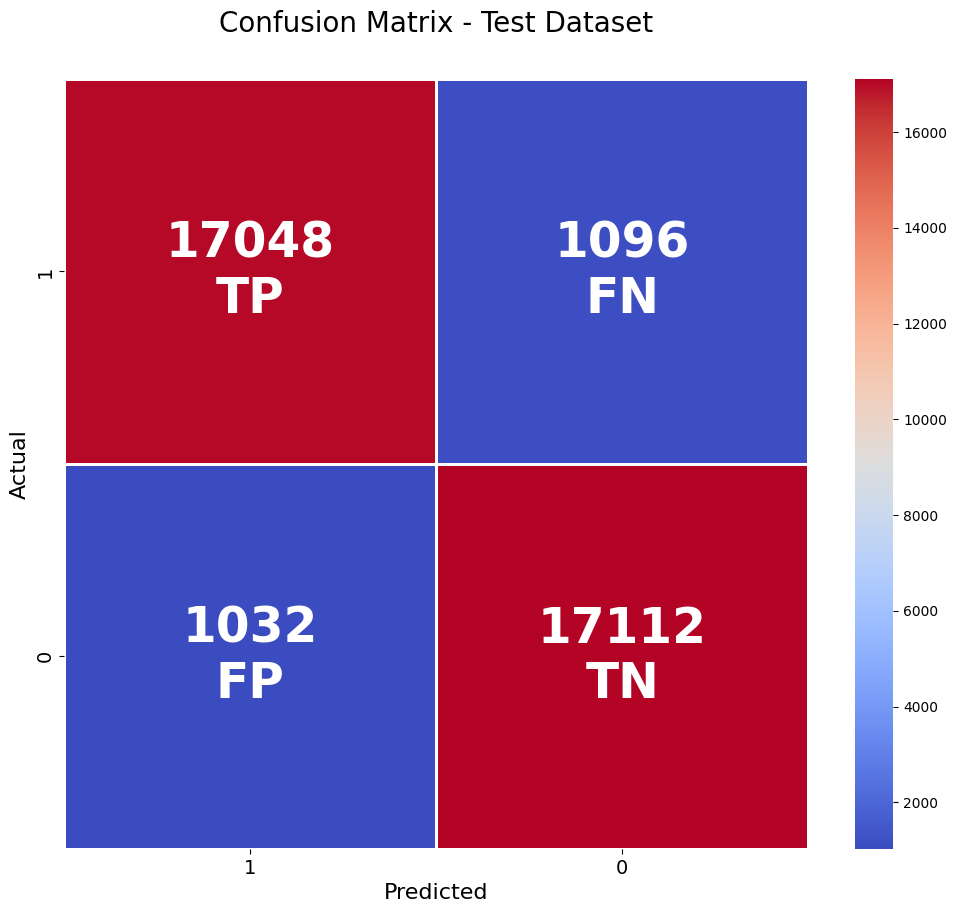

In [29]:
# combine values with text for annotations
tp = str(bcm[0][0].int().item()) + '\nTP'
fn = str(bcm[0][1].int().item()) + '\nFN'
fp = str(bcm[1][0].int().item()) + '\nFP'
tn = str(bcm[1][1].int().item()) + '\nTN'

# create array with annotations
bcm_annot = np.array([tp, fn, fp, tn]).reshape((2,2))

# build and display confusion matrix
plt.figure(figsize = (12,10))
sns.heatmap(data=bcm.cpu(), annot=bcm_annot, annot_kws={'fontsize': 35, 'fontweight': 'heavy'}, fmt='', linewidths=2, linecolor='white', cmap='coolwarm')
plt.title('Confusion Matrix - Test Dataset', y=1.05, fontsize=20)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.xticks(ticks=[0.5, 1.5],labels=['1', '0'], fontsize=14)
plt.yticks(ticks=[0.5, 1.5],labels=['1', '0'], fontsize=14)
plt.show()